## Iterative pre-whitening examples
### KIC 7760680

In this notebook, we'll run the full Iterative pre-whitening (IPW) analysis of the Slowly Puslating B-type stars KIC 7760680 and then do some asteroseismolog with the results.

We'll just load up the data, and start the IPW, using a running window of $2~{\rm d^{-1}}$, and we'll extract the frequencies in order of highest SNR.

For this notebook, you'll need to download: [kic7760680_lc.dat](https://iacerasmus.github.io/ERASMUS2022/data/kic7760680_lc.dat)

In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt

from pythia.utils.resampling import run_mean_smooth
from pythia.timeseries.lombscargle import LS_periodogram
from pythia.timeseries.iterative_prewhitening import run_ipw

import matplotlib
matplotlib.use('nbagg')

plt.rcParams.update({
    "text.usetex": True,
        "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
plt.rcParams.update({
    "pgf.rcfonts": False,
    "pgf.texsystem": "pdflatex",
    "pgf.preamble": "\n".join([
         r"\usepackage{amsmath}",
         r"\usepackage[utf8x]{inputenc}",
         r"\usepackage[T1]{fontenc}",
         r"\usepackage{cmbright}",
    ]),
})

plt.rcParams['xtick.labelsize']=18
plt.rcParams['ytick.labelsize']=18

<IPython.core.display.Javascript object>


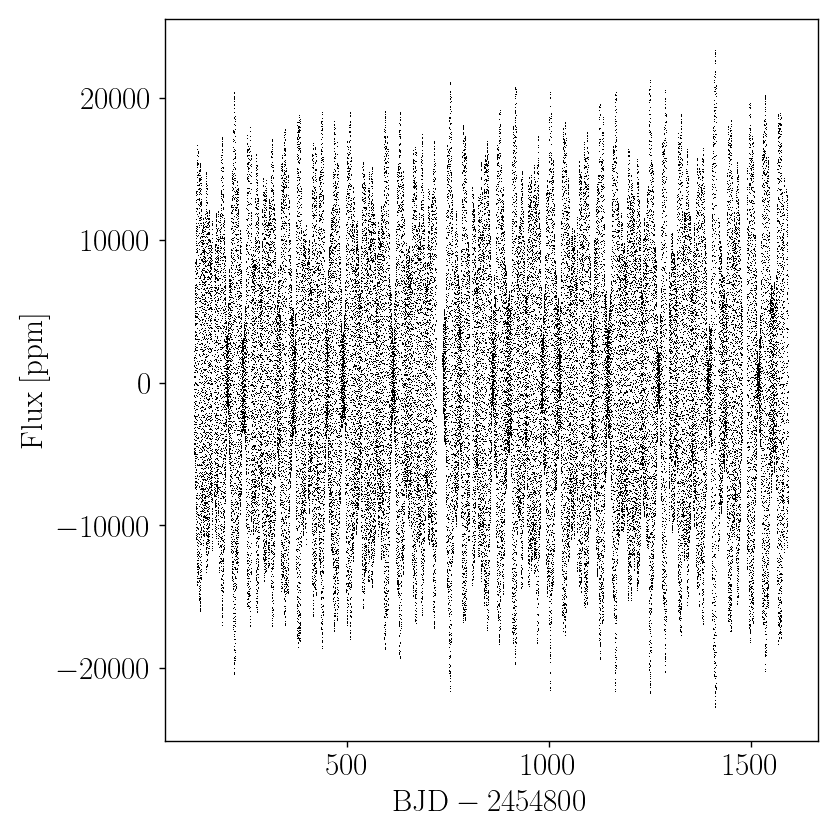

In [2]:
times, flux = np.loadtxt('../data/kic7760680_lc.dat').T

fig, ax = plt.subplots(1,1,figsize=(6.69,6.69),num=1)
ax.plot(times, flux, 'k,')
ax.set_xlabel(r'${\rm BJD-2454800}$',fontsize=18)
ax.set_ylabel(r'${\rm Flux~[ppm]}$',fontsize=18)
fig.tight_layout()


In [3]:
nu, amp = LS_periodogram(times,flux-np.mean(flux))

<IPython.core.display.Javascript object>


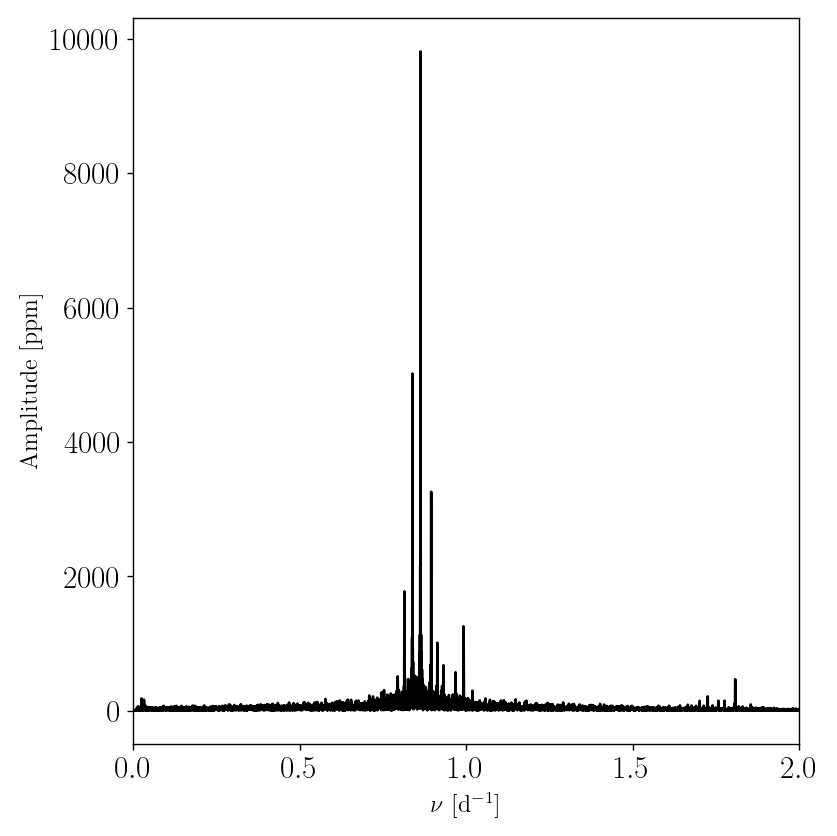

In [4]:
fig,ax = plt.subplots(1,1,figsize=(6.6957,6.6957),num=2)
ax.plot(nu,amp,'k-')
ax.set_xlabel(r'$\nu\,\,{\rm [d^{-1}]}$',fontsize=14)
ax.set_ylabel(r'${\rm Amplitude\,\,[ppm]}$',fontsize=14)
ax.set_xlim(0.,2)
fig.tight_layout()

As we can see from the light curve, there's a lot of beating going on. Seeing this, we know to expect at least a few closely separated frequencies!

## If you want to run this yourself, please uncomment this and have a fun time waiting (~10-15 minutes)

In [5]:
# yerr = 800* np.ones_like(times)
# residuals, model, offsets, \
# frequencies, amplitudes, \
# phases, stop_criteria, noise_level = run_ipw(times,flux-np.mean(flux), yerr, snr_stop_criteria=5.6, max=2.,
#                                              order_by_snr=True, use_snr_window=True, snr_window=1.,maxiter=60)


# print('The IPW analysis has found {:d} significant frequencies'.format(len(frequencies)))
# np.savetxt('../data/kic7760680_ipw.dat', np.array([offsets, amplitudes, frequencies, phases, stop_criteria]).T)

Otherwise, please feel free to simply load the frequencies from below and continue on!

Now that it's run, let's take a look at the model, the residual signal, and the frequencies that we found.

In [6]:
offsets, amplitudes, frequencies, phases, stop_criteria = np.loadtxt('../data/kic7760680_ipw.dat').T

In [14]:
print(' C + A*sin( 2*pi*f*(t-t0)+phi )')
t0 = 0.5 * (times[-1]+times[0])
sine_ = np.zeros_like(times)
outstr = '{} -- C: {:.6f} -- A: {:.6f} -- f: {:.6f} -- phi: {:.6f} -- SNR: {:.6f}'
for ii,freq in enumerate(frequencies):
    print(outstr.format(ii, offsets[ii], amplitudes[ii], freq, phases[ii],stop_criteria[ii]))
    sine = offsets[ii] + amplitudes[ii] * np.sin(2.*np.pi*freq*(times-t0)+phases[ii])
    sine_ += sine
residuals = flux-sine_

 C + A*sin( 2*pi*f*(t-t0)+phi )
0 -- C: -0.000028 -- A: 9866.861059 -- f: 0.862874 -- phi: -1.078658 -- SNR: 1543.183733
1 -- C: 0.000000 -- A: 5027.780728 -- f: 0.838526 -- phi: 2.426711 -- SNR: 781.497421
2 -- C: 0.000000 -- A: 3400.463973 -- f: 0.894847 -- phi: 0.697600 -- SNR: 534.928554
3 -- C: 0.000000 -- A: 1753.231056 -- f: 0.814312 -- phi: -2.681713 -- SNR: 271.694962
4 -- C: 0.000000 -- A: 1385.250048 -- f: 0.992187 -- phi: 0.076164 -- SNR: 222.601953
5 -- C: 0.000000 -- A: 923.210475 -- f: 0.913397 -- phi: 0.273239 -- SNR: 146.005933
6 -- C: 0.000000 -- A: 464.470761 -- f: 1.808314 -- phi: 3.037257 -- SNR: 112.102343
7 -- C: 0.000000 -- A: 619.884261 -- f: 0.931817 -- phi: -2.246461 -- SNR: 98.545903
8 -- C: 0.000000 -- A: 527.487143 -- f: 0.967846 -- phi: -2.908431 -- SNR: 84.474666
9 -- C: 0.000000 -- A: 243.675025 -- f: 1.725744 -- phi: 3.065513 -- SNR: 65.583140
10 -- C: 0.000000 -- A: 464.770434 -- f: 0.794265 -- phi: -1.014160 -- SNR: 71.705150
11 -- C: 0.000000 -- A: 

<IPython.core.display.Javascript object>


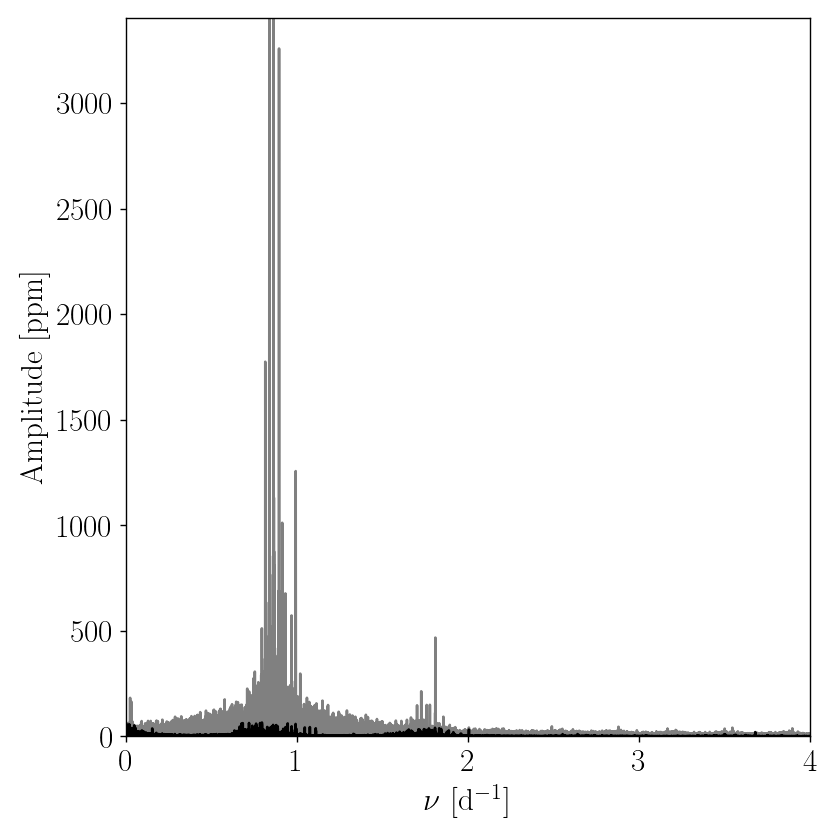

In [16]:
nu_, amp_ = LS_periodogram(times, residuals)
fig,ax = plt.subplots(1,1,figsize=(6.6957,6.6957), num=3)

#     ax.axvline(freq, linestyle='--',color='red',alpha=0.4)
#     ax.axhline(amplitudes[ii], linestyle='--',color='red',alpha=0.4)

ax.plot(nu, amp,'-',color='grey')
ax.plot(nu_,amp_,'k-')
ax.set_xlabel(r'$\nu\,\,{\rm [d^{-1}]}$',fontsize=18)
ax.set_ylabel(r'${\rm Amplitude\,\,[ppm]}$',fontsize=18)
ax.set_xlim(0., 4)
ax.set_ylim(0., 3400)
fig.tight_layout()

You might notice that we extracted 50 significant frequenices, but that we were still at an SNR~10.
We certainly could have continued, but for the sake of the example, let's stop here. 

Clearly, there's a lot of sifnificant signal left, but let's see what we can do with what we've found.

<IPython.core.display.Javascript object>


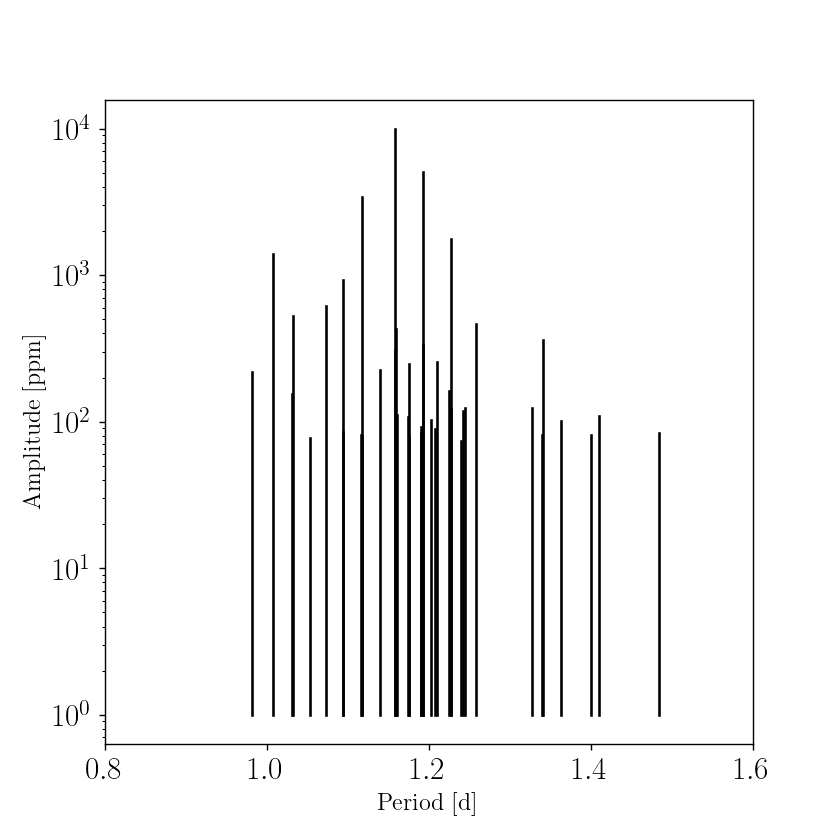

Text(0.5, 0, '${\\rm Period~[d]}$')

In [17]:
fig,ax = plt.subplots(1,1,figsize=(6.6957,6.6957), num=4)
for ii, freq_ in enumerate(frequencies):
    ax.plot([1./freq_,1./freq_], [1, amplitudes[ii]], color='black')

ax.set_yscale('log')
ax.set_xlim(0.8,1.6)
ax.set_ylabel(r'${\rm Amplitude~[ppm]}$',fontsize=14)
ax.set_xlabel(r'${\rm Period~[d]}$',fontsize=14)


According to asymptotic theory, we know that g-mode pulsations of constant ${(\ell, m)}$ and successive $n$ are expected to have an equidistant spacing in __period__.

However, effects like rotation and the presence of a chemical gradient can perturb g modes from having a constant period spacing.

<IPython.core.display.Javascript object>


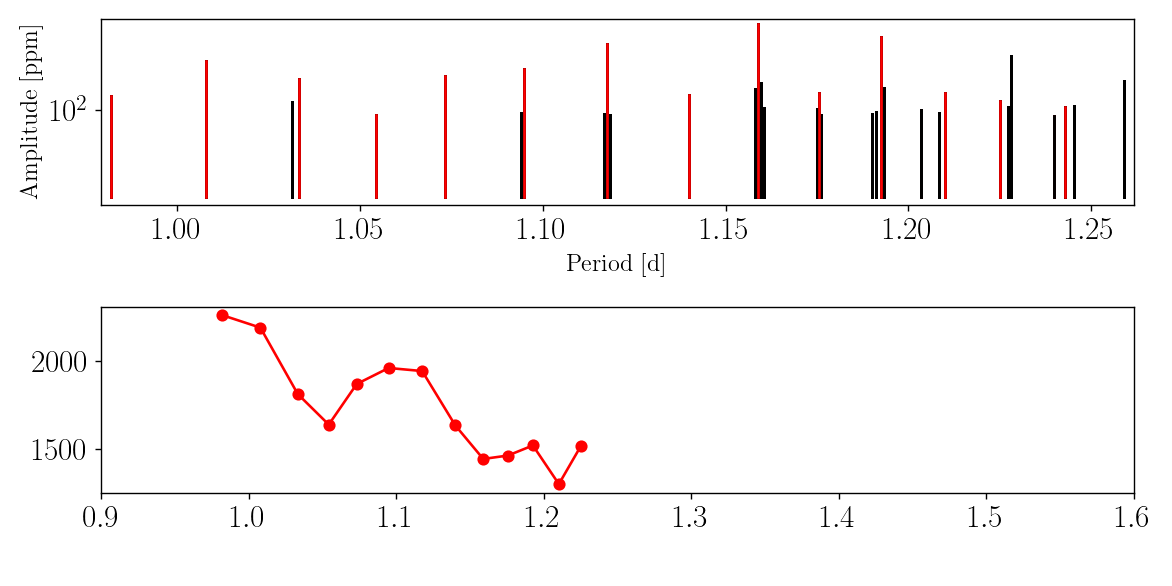

In [19]:
%matplotlib notebook
from ipywidgets import interact


def sort_on_x(x,y):
    zipped = list(zip(x,y))
    zipped.sort(key=lambda x:x[0])
    x,y = list(zip(*zipped))
    return np.array(x), np.array(y)


# plt.rcParams['backend'] = 'TkAgg'

periods = 1./frequencies
amplitudes_ = amplitudes[ ((periods>0.9) & (periods<1.7))]
periods_ = periods[ ((periods>0.9) & (periods<1.7))]

periods_, amplitudes_ = sort_on_x(periods_, amplitudes_)


fig,axes = plt.subplots(2,1,figsize=(6.6957*1.4,6.6957*0.7), num=5)

for ii, per in enumerate(periods_):
    axes[0].plot([per, per], [1., amplitudes_[ii]], color='black')

axes[0].set_yscale('log')
axes[0].set_xlim(0.9,1.6)
axes[0].set_ylabel(r'${\rm Amplitude~[ppm]}$',fontsize=14)
axes[0].set_xlabel(r'${\rm Period~[d]}$',fontsize=14)

axes[1].set_xlabel(r'${\rm Period~[d]}$',fontsize=15)
axes[1].set_ylabel(r'${\rm \Delta P~[s]}$',fontsize=15)

fig.tight_layout()

selected_periods, selected_amplitudes, delta_p, p_ = [], [], [], []

def onclick(event):

    global selected_periods 
    global selected_amplitudes
    if (event.button == 3):
        x_ = event.xdata
        y_ = event.ydata 
        dists = np.sqrt( (x_ - periods_)**2 )
        idf = np.argmin( dists )
        selected_periods.append(periods_[idf])
        selected_amplitudes.append(amplitudes_[idf])
     
    if (event.button == 2):
        xd = event.xdata
        yd = event.ydata 
        dists = np.sqrt( (xd - selected_periods)**2 )
        idr = np.argmin( dists )
        del selected_periods[idr]
        del selected_amplitudes[idr]
    
    for ii, per in enumerate(periods_):
        axes[0].plot([per, per], [1., amplitudes_[ii]], color='black')
    
    for ii, sp in enumerate(selected_periods):
        axes[0].plot([sp, sp], [1, selected_amplitudes[ii]], 'r-')

    if len(selected_periods)>1:
        global delta_p
        delta_p = []
        axes[1].clear()
        for ii, pi in enumerate(sorted(selected_periods[1:])):
            delta_p.append( 86400. * (pi - sorted(selected_periods)[ii] ) )
        axes[1].plot( sorted(selected_periods)[:-1], delta_p, 'r-o')
        axes[1].set_xlim(0.9, 1.6)
    
    fig.canvas.draw_idle()
    
# Create an hard reference to the callback not to be cleared by the garbage collector
ka = fig.canvas.mpl_connect('button_press_event', onclick)